<a href="https://colab.research.google.com/github/Nikhilp18/American-Sign-Language-Image-Classification/blob/main/ASL_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# American Sign Language

American Sign Language (ASL) is a comprehensive, natural language with English-like syntax that has many of the same linguistic characteristics as spoken languages. Hand and face gestures are used to convey meaning in ASL. Many deaf and hard-of-hearing individuals in North America use it as their primary language.The precise origins of ASL are unknown, however some believe it evolved more than 200 years ago from the mixing of local sign languages and French Sign Language (LSF). Today's ASL has certain parts of LSF as well as the original local sign languages; over time, these have merged and developed into a rich, sophisticated, and mature language. Modern ASL and modern LSF are different languages. While they still include some identical indicators, they can no longer be understood by each other's users.
<br>ASL is a fully unique and distinct language from English. It has all of the basic properties of language, including its own rules for pronunciation, word creation, and word order. While every language contains means of indicating distinct purposes, such as asking a question rather than making a statement, the manner in which this is done varies throughout languages.
<br>Specific ways of expressing concepts in ASL, as in other languages, vary as much as ASL users themselves. ASL includes regional accents and dialects, much as some English words are spoken differently in different regions of the country; similarly, ASL has regional variations in the rhythm of signing, pronunciation, slang, and signs employed. As with spoken languages, other societal variables such as age and gender can influence ASL usage and add to its diversity.
ASL includes fingerspelling, which is used to sign out English words. Each letter in the fingerspelled alphabet corresponds to a different handshape. Fingerspelling is frequently employed to signify proper names or the English term for something.

>The dataset contains 26 alphabets classes and 3 special character classes viz. SPACE, DELETE and NOTHING. The training dataset contains 87000 images of 200 x 200 pixels. The dataset is downloaded from Kaggle from the link: https://www.kaggle.com/datasets/grassknoted/asl-alphabet

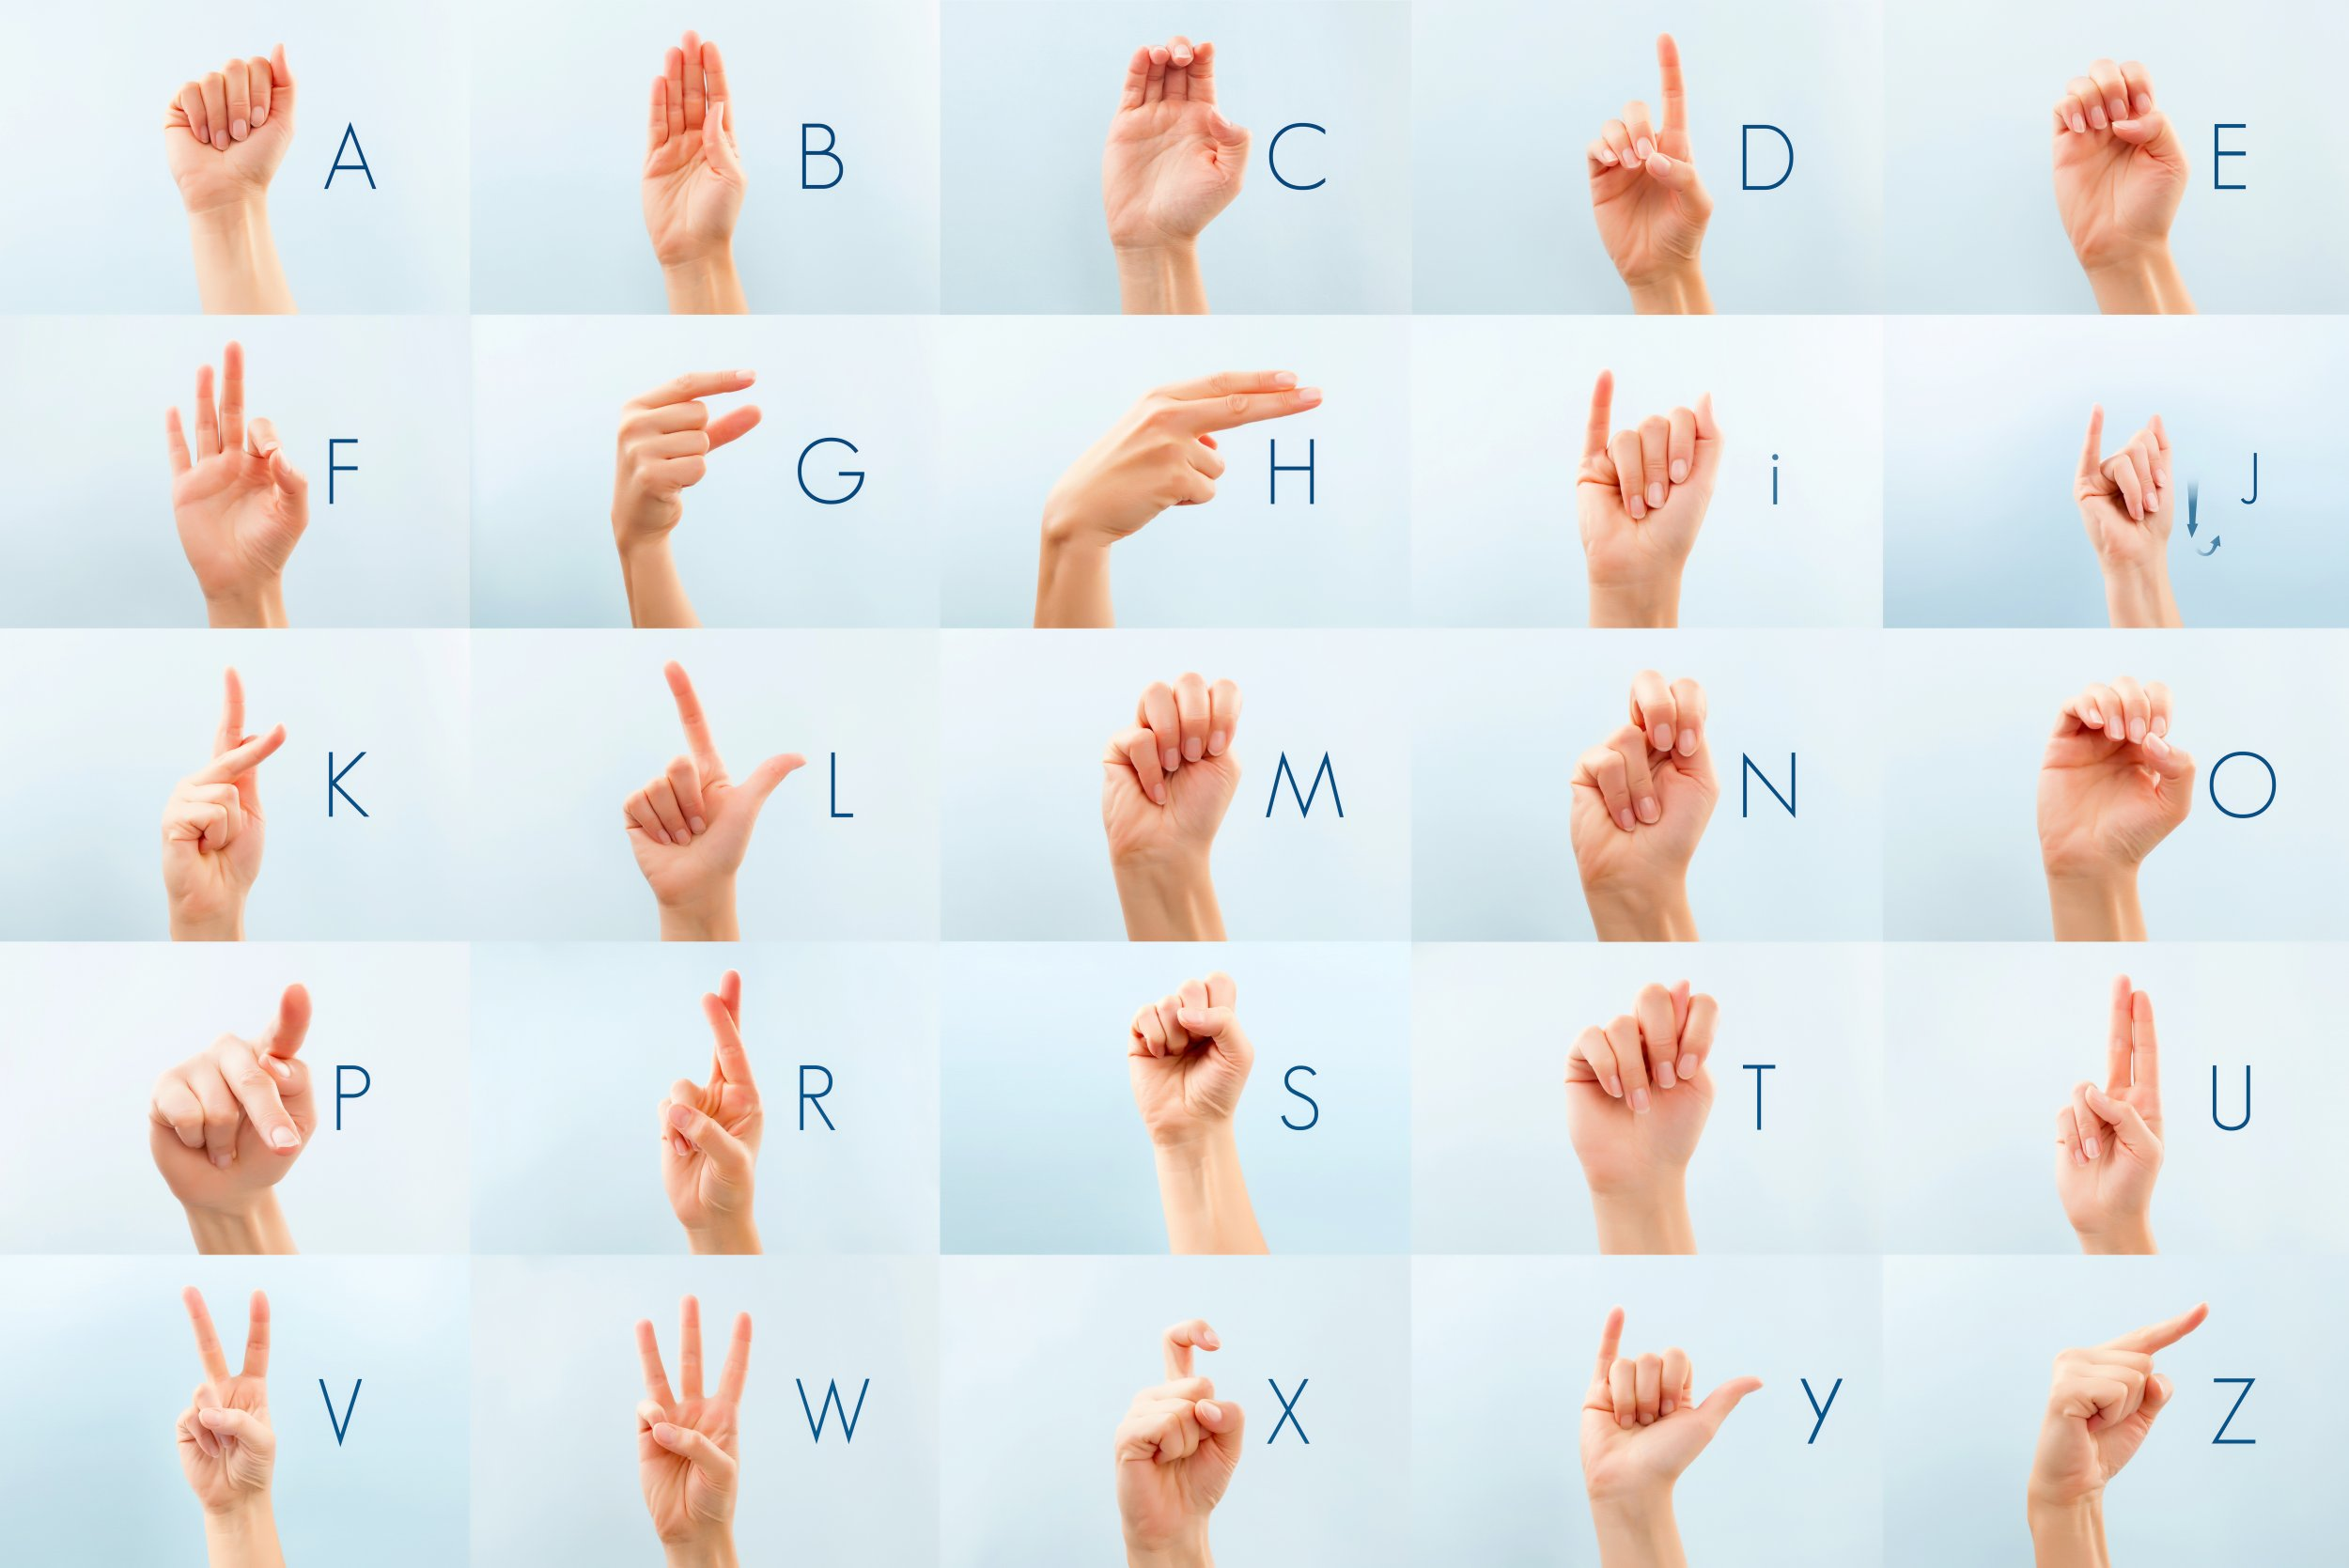


### Import Required libraries

In [1]:
!pip install jovian opendatasets --upgrade --quiet

     |████████████████████████████████| 68 kB 3.8 MB/s 


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix, accuracy_score
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px

import opendatasets as od

### Downloading the dataset

The dataset is downloaded from Kaggle. The link is given below:
<br>https://www.kaggle.com/datasets/grassknoted/asl-alphabet

In [3]:
data_url = 'https://www.kaggle.com/datasets/grassknoted/asl-alphabet'

In [4]:
od.download(data_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: nikhilpurao
Your Kaggle Key: ··········


100%|██████████| 1.03G/1.03G [00:12<00:00, 85.6MB/s]


### Segregating data in train, test and validation sets

In [5]:
# Saving address of root directory in a variable
notebook_path = os.getcwd()

In [6]:
data_dir = './asl-alphabet'

In [7]:
os.listdir(data_dir)

['asl_alphabet_test', 'asl_alphabet_train']

In [8]:
# We remove test data file provided.
shutil.rmtree(data_dir+'/asl_alphabet_test')

In [9]:
# Moving the remaing subfolder (i.e. provided train set) root directory
source = data_dir+'/asl_alphabet_train/asl_alphabet_train'
destination = './'
shutil.move(source,destination)

'./asl_alphabet_train'

In [10]:
# Deleting the empty folder
shutil.rmtree('./asl-alphabet')

In [11]:
# Renaming the train data in root directory as our primary dataset
source = './asl_alphabet_train'
destination = './asl-alphabet'
os.rename(source,destination)

In [12]:
data_dir = './asl-alphabet'

In [13]:
# Looking at all the classes
os.listdir(data_dir)

['D',
 'A',
 'S',
 'space',
 'Y',
 'V',
 'W',
 'R',
 'E',
 'P',
 'N',
 'M',
 'U',
 'K',
 'del',
 'L',
 'Z',
 'X',
 'J',
 'O',
 'nothing',
 'G',
 'T',
 'F',
 'C',
 'B',
 'Q',
 'H',
 'I']

In [14]:
# Organiza data in train, test and valid
os.chdir(data_dir)
if os.path.isdir('train/A/') is False:
    os.mkdir('train')
    os.mkdir('test')
    os.mkdir('valid')
    
    labels = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U',
              'V','W','X','Y','Z','del','nothing','space']
    
    for i in labels:
        shutil.move(f'{i}','train')
        os.mkdir(f'valid/{i}')
        os.mkdir(f'test/{i}')
        
        valid_samples = random.sample(os.listdir(f'train/{i}'),300)  # Moving 300 samples to validation set
        for j in valid_samples:
            shutil.move(f'train/{i}/{j}',f'valid/{i}')
            
        test_samples = random.sample(os.listdir(f'train/{i}'),100)   # Moving 300 samples to test set
        for j in test_samples:
            shutil.move(f'train/{i}/{j}',f'test/{i}')
            
os.chdir(notebook_path)

In [15]:
# Defining train, test and validation paths
train_path = data_dir+'/train'
valid_path = data_dir+'/valid'
test_path = data_dir+'/test'

## Neural Networks

In [16]:
# Detecting GPU and if it exist setting memory growth
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print('Num GPU Available: ', len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPU Available:  1


### MobileNet
MobileNets are a family of TensorFlow mobile-first computer vision models that are developed to optimise accuracy while keeping in mind the limited resources of an on-device or embedded application. MobileNets are low-latency, low-power models that may be customised to fit the resource restrictions of a wide range of use cases. They may be used to build classification, detection, embeddings, and segmentation systems.
<br>Depthwise separable convolutions are used by MobileNet. When compared to the network with ordinary convolutions of the same depth in the network, it greatly reduces the number of parameters. As a result, lightweight deep neural networks are created. MobileNet is a CNN class that was open-sourced by Google, providing a fantastic starting point for training our classifiers that are incredibly tiny and extremely fast.


In [17]:
# Using predefined MobileNet model to train the data
mobile = tf.keras.applications.mobilenet.MobileNet()

17235968/17225924 [==============================] - 0s 0us/step


### Preprocessing
Preprocessing images with preprocessing function of mobilenet and converting image to a target size of 224 x 224 pixel. We will not shuffle the test datasets as we will need its test data-labels later.

In [18]:
train_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=train_path, target_size= (224,224), batch_size= 10)

valid_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size= (224,224), batch_size= 10)

test_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=test_path, target_size= (224,224), batch_size= 10, shuffle = False)

Found 75400 images belonging to 29 classes.
Found 8700 images belonging to 29 classes.
Found 2900 images belonging to 29 classes.


In [19]:
# Model Summary
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

### Replacing the prediction layer of MobileNet with the number of classes available in our dataset
The original MobileNet model was trained to output 1000 different classes. We will replace with to output 29 distict classes present in our dataset i.e., A-Z and 3 special characters SPACE, DELETE, NOTHING.

In [20]:
x = mobile.layers[-2].output
output = Dense(units = 29, activation = 'softmax')(x)

In [21]:
model = Model(inputs = mobile.input, outputs = output)

### Defining trainable layers
We will set only last 23 layers out of 88 layers of MobileNet model as trainable and train the model to our dataset.

In [22]:
for layer in model.layers[:-23]:
    layer.trainable = False

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

#### As we can see out of 4.2M parameters, only 2.9M parameters are now trainable.

### Compiling the model
We will compile the model with following settings:
1. Optimizer = Adam
2. Learning rate = 0.0001
3. Loss function = Categorical crossentropy
4. Metric used = Accuracy

In [24]:
model.compile(optimizer = Adam(learning_rate = 0.0001),loss = 'categorical_crossentropy', metrics = ['accuracy'])

### Fitting the model
We will fit the model with following settings:
1. Epochs = 10
2. Verbosity = 2 

In [25]:
model.fit(x = train_batches, validation_data = valid_batches, epochs = 10, verbose = 2)

Epoch 1/10
7540/7540 - 184s - loss: 0.1043 - accuracy: 0.9720 - val_loss: 0.0164 - val_accuracy: 0.9952 - 184s/epoch - 24ms/step
Epoch 2/10
7540/7540 - 169s - loss: 0.0283 - accuracy: 0.9933 - val_loss: 0.0019 - val_accuracy: 0.9994 - 169s/epoch - 22ms/step
Epoch 3/10
7540/7540 - 166s - loss: 0.0173 - accuracy: 0.9963 - val_loss: 0.0058 - val_accuracy: 0.9990 - 166s/epoch - 22ms/step
Epoch 4/10
7540/7540 - 165s - loss: 0.0109 - accuracy: 0.9973 - val_loss: 4.7888e-04 - val_accuracy: 0.9997 - 165s/epoch - 22ms/step
Epoch 5/10
7540/7540 - 165s - loss: 0.0094 - accuracy: 0.9979 - val_loss: 0.0035 - val_accuracy: 0.9990 - 165s/epoch - 22ms/step
Epoch 6/10
7540/7540 - 165s - loss: 0.0074 - accuracy: 0.9984 - val_loss: 1.3597e-04 - val_accuracy: 1.0000 - 165s/epoch - 22ms/step
Epoch 7/10
7540/7540 - 165s - loss: 0.0069 - accuracy: 0.9986 - val_loss: 5.3635e-04 - val_accuracy: 0.9997 - 165s/epoch - 22ms/step
Epoch 8/10
7540/7540 - 166s - loss: 0.0050 - accuracy: 0.9986 - val_loss: 1.9660e-04 

#### The model is able to achieve an accuarcy of about 99% on both training set and validation set respectively at the end of 10th epoch.

In [26]:
# Getting test labels
test_labels = test_batches.classes

In [27]:
# Making predicts on test set
preds = model.predict(x = test_batches, verbose = 0)

In [28]:
# Getting a one-hot-encoded vector to compare against test labels
preds = preds.argmax(axis = 1)

### Accuracy of model on test set

In [29]:
accuracy = round(accuracy_score(test_labels, preds), 3)
print('Accuracy :', accuracy*100,' %', '\n')

Accuracy : 100.0  % 



#### The model is able to achieve an accuracy of 100% on test dataset

In [30]:
fig = px.imshow(confusion_matrix(test_labels, preds),text_auto='.2f',
                    title = 'Heatmap of Confusion matrix')
fig.show()

## Inferences and Conclusion
The inferences and conclusions made are listed below:
1. The dataset was split into training, validation and test sets.
2. The predefined MobileNet model is used to train the data.
3. The images in the dataset were preprocessed with the preprocessing function of MobileNet.
4. The prediction layer of MobileNet was replaced with the number of distinct classes in our dataset.
5. Last 23 layers out of 88 layers of MobileNet were set to trainable.
6. The model is able to achieve accuarcy of 99.89 % and 99.98% on training set and validation set respectively at the end of 10th epoch.
7. The model is able to achieve an accuracy of 100% on test dataset

## References and future work
All the useful links are listed below:
1. https://www.kaggle.com/datasets/grassknoted/asl-alphabet
2. https://deeplizard.com/
3. https://keras.io/api/applications/mobilenet/
4. https://www.tensorflow.org/